# Traffic light detection
## Phase 2: Create data-set for traffic light detection
### Members of the team: Avigail Wilk, Hadass Wittow and Nechama Verbov
### Credits:
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.memmap.html

In [1]:
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import numpy as np

### Importing data

In [2]:
#Database location on Disk
gt_dir = r'gtFine'
imgs_dir = r'leftImg8bit'

gt_train_path = os.path.join(gt_dir, 'train')
imgs_train_path = os.path.join(imgs_dir, 'train')
gt_val_path = os.path.join(gt_dir, 'val')
imgs_val_path = os.path.join(imgs_dir, 'val')

def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    imgs = []
    jsons = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
        jsons += glob.glob(os.path.join(new_gt_path, "*.json"))
    imgs.sort()
    jsons.sort()
    return imgs, jsons

train_imgs, train_jsons = get_files(imgs_train_path, gt_train_path)
val_imgs, val_jsons = get_files(imgs_val_path, gt_val_path)

### Creating directory for traffic light training and validation data-set

In [3]:
if not os.path.exists("DATA_DIR"):
    os.mkdir('DATA_DIR')
    os.mkdir("DATA_DIR/TRAIN")
    os.mkdir("DATA_DIR/VAL")

### Cropping image to fit area of traffic light or area with no traffic light

In [4]:
def crop_pic(mat, x, y):
    if x-40 < 0 or y-40 < 0 or x+40 > mat.shape[1] or y + 40 > mat.shape[0]:
        return None

    c =  mat[y - 40 : y + 41, x - 40 : x + 41, 0:3]

    return c

### Finds pixels with traffic light and pixels without

In [5]:
def true_and_false_pixels(idx, jsons):
    positive_pixel = []
    neg_pixel = []
    
    with open(jsons[idx]) as label_json:
        data = label_json.read()
        obj = json.loads(data)

    for obj1 in obj['objects']:
        if obj1['label'] == "traffic light":
            positive_pixel = obj1['polygon'][0]
            break
            
    for obj2 in obj['objects']:
        if obj2['label'] == "car":
            neg_pixel = obj2['polygon'][0]
            break
    
    return positive_pixel, neg_pixel

### Iterates over images to create a unique dataset for traffic light detection

In [6]:
def iterate_imgs(data_file, label_file, imgs, jsons):
    with open(data_file, "wb") as  data, open(label_file, "wb") as labels:
        label_list = []
        index = 0
            
        for idx,img in enumerate(imgs):

            im = plt.imread(img)

            true, false = true_and_false_pixels(idx, jsons)

            if true != []:
                cropped = crop_pic(im, *true)
                if cropped is not None:
                    cropped.tofile(data)
                    label_list.append(1)

            if false != []:
                cropped = crop_pic(im, *false)
                if cropped is not None:
                    cropped.tofile(data)
                    label_list.append(0)
    
        np.array(label_list, dtype=np.uint8).tofile(labels)

In [7]:
iterate_imgs("DATA_DIR/TRAIN/data.bin", "DATA_DIR/TRAIN/labels.bin", train_imgs, train_jsons)

In [8]:
iterate_imgs("DATA_DIR/VAL/data.bin", "DATA_DIR/VAL/labels.bin", val_imgs, val_jsons )

### Showing a few images from training data-set

In [9]:
def show_train_dataset(fname, amount):
    data = np.memmap(fname, dtype=np.float32,shape=(amount,81,81,3)) 
    return data
    
data = show_train_dataset(r'DATA_DIR/TRAIN/data.bin', 12)

In [10]:
def show_train_labels(gname, amount):
    labels = np.memmap(gname, dtype=np.uint8, shape = amount)
    return labels

labels = show_train_labels(r'DATA_DIR/TRAIN/labels.bin', 12)

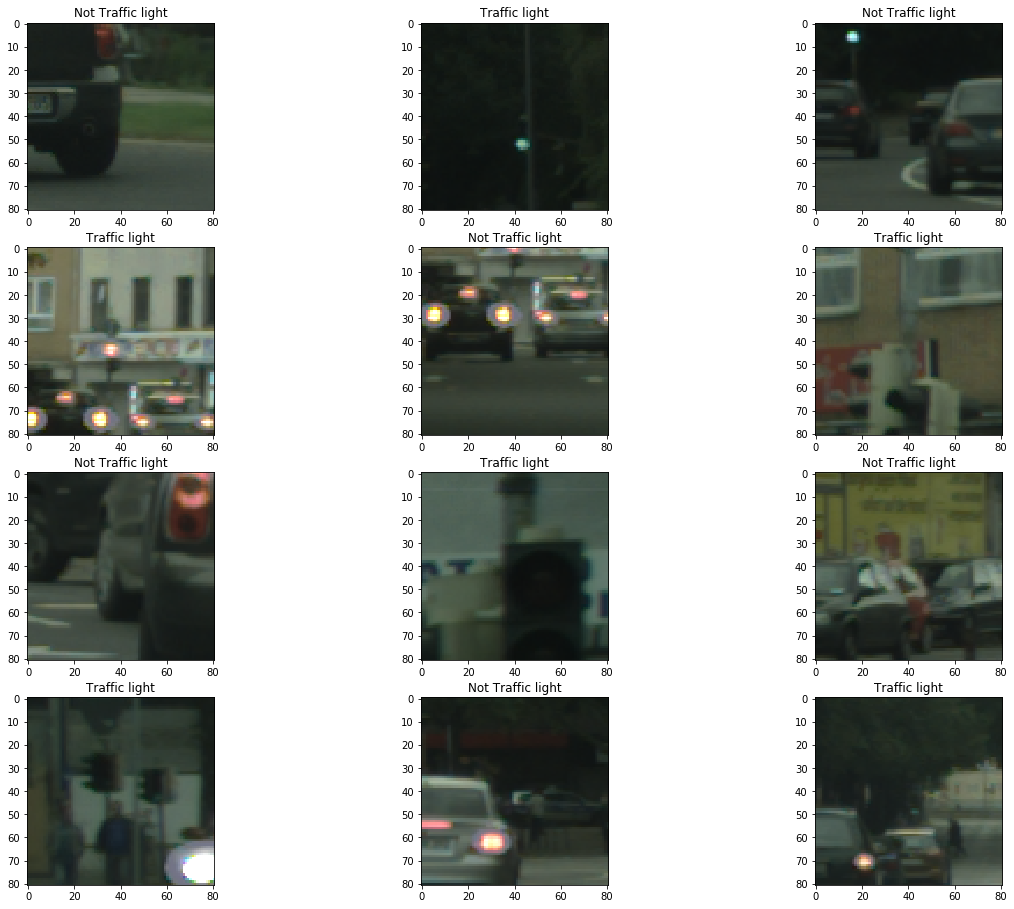

In [11]:
fig = plt.figure(figsize=(20,20))
    
for i, img in enumerate(data):
    a = fig.add_subplot(5,3,i+1)
    a.imshow(img)
    a.title.set_text("Traffic light" if labels[i] else "Not Traffic light");
plt.show()

### Showing a few images from validation data-set

In [12]:
def show_val_dataset(fname, amount):
    data = np.memmap(fname, dtype=np.float32,shape=(amount,81,81,3)) 
    return data
    
data = show_val_dataset(r'DATA_DIR/VAL/data.bin', 12)

In [17]:
def show_val_labels(gname, amount):
    labels = np.memmap(gname, dtype=np.uint8, shape = amount)
    return labels

labels = show_val_labels(r'DATA_DIR/TRAIN/labels.bin', 12)

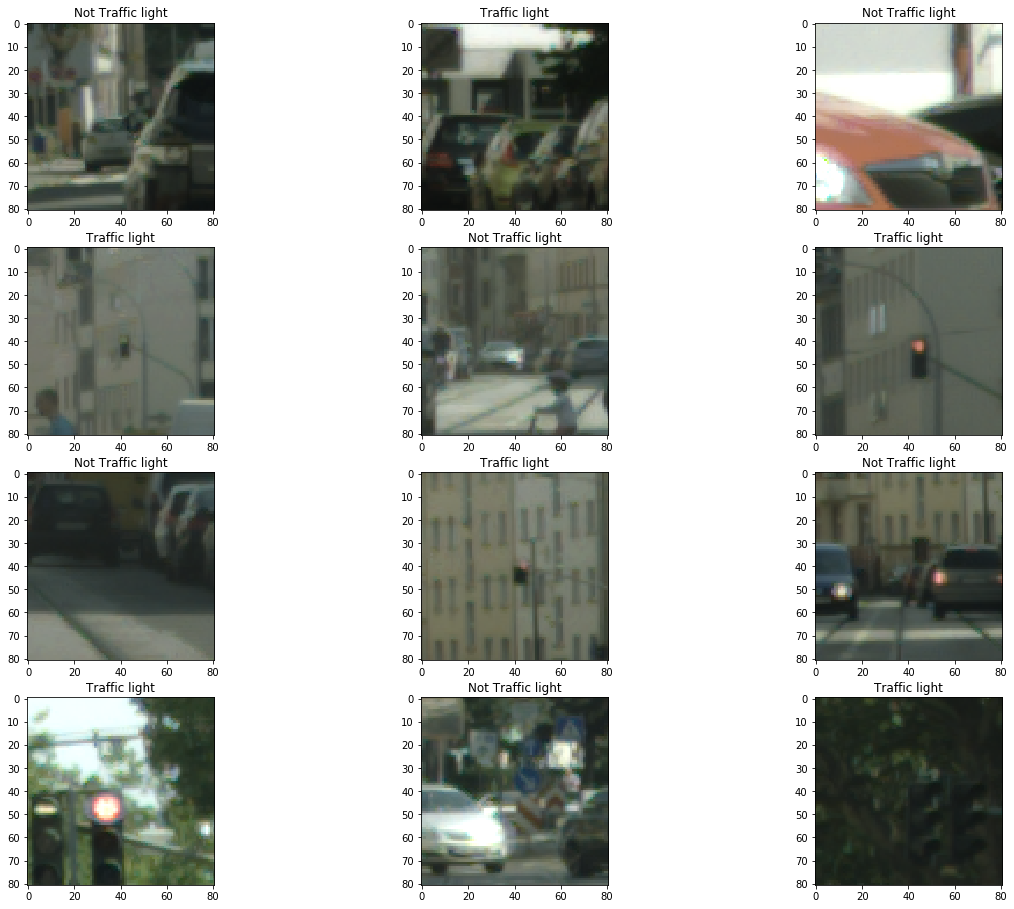

In [18]:
fig = plt.figure(figsize=(20,20))
    
for i, img in enumerate(data):
    a = fig.add_subplot(5,3,i+1)
    a.imshow(img)
    a.title.set_text("Traffic light" if labels[i] else "Not Traffic light");
plt.show()